# 0- Import libraries

In [ ]:
#Installing the required package
!pip install split-folders

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import random
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 1- Prepare dataset

## 1.0 Download the dataset

In [ ]:
%%capture

#https://drive.google.com/file/d/17t-aerfllBLSU0eQpgUP4kwe1nBDMGFc/view?usp=sharing
!rm -f Pistachio_Image_Dataset.zip
!gdown 17t-aerfllBLSU0eQpgUP4kwe1nBDMGFc
!rm Pistachio_Image_Dataset
!unzip /content/Pistachio_Image_Dataset.zip

## 1.1- Load dataset

We are splitting the dataset in the following format:
*   80% Training
*   10% Validation
*   10% Test

In [ ]:
data_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset"
splitfolders.ratio(data_dir, output="output", seed=101, ratio=(.8, .1, .1))

Copying files: 2148 files [00:00, 6156.96 files/s]


New paths that we will use for Data Augmentation and Displaying Images

In [ ]:
train_path = './output/train'
test_path = './output/test'
val_path = './output/val'

## 1.2- Image Preprocessing

In [ ]:
img = mpimg.imread('./output/train/Kirmizi_Pistachio/kirmizi 62.jpg')
img1 = mpimg.imread('./output/train/Siirt_Pistachio/siirt 603.jpg')

In [ ]:
img.shape, img1.shape

((600, 600, 3), (600, 600, 3))

Our original images have a size of (600,600) so we will be using 512 as the image size to keep the size as a multiple of 64. We could use resizing further but since our dataset is small, we will not be resizing it a lot and using 512 for our purpose.

In [ ]:
img_size = 512
batch = 32

labels = []
for i in os.listdir(train_path):
    labels+=[i]

labels

['Siirt_Pistachio', 'Kirmizi_Pistachio']

## 1.3- Explore the dataset

### 1.3.1 - Show basic information

In [ ]:
# Function to count the number of images in a folder
def count_images(folder_path):
    return len([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Print the number of images in each folder
print(f"Number of images in {train_path}: {count_images(train_path)}")
print(f"Number of images in {test_path}: {count_images(test_path)}")
print(f"Number of images in {val_path}: {count_images(val_path)}")

Number of images in ./output/train: 0
Number of images in ./output/test: 0
Number of images in ./output/val: 0


### 1.3.2- Do some basic statistics

In [ ]:
from PIL import Image

# Function to calculate mean and standard deviation of pixel values in images
def calculate_image_statistics(folder_path):
    pixel_values = []
    image_count = 0

    # Loop through each image in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            # Convert the image to a NumPy array
            image_array = np.array(image)

            # Flatten the array to a 1D array and append to the list
            pixel_values.extend(image_array.flatten())

            image_count += 1

    # Calculate mean and standard deviation
    mean_value = np.mean(pixel_values)
    std_dev = np.std(pixel_values)

    return mean_value, std_dev, image_count

# Calculate statistics for images in the train_path
mean_train, std_train, count_train = calculate_image_statistics(train_path)

# Print the statistics
print(f"Number of images in {train_path}: {count_train}")
print(f"Mean pixel value: {mean_train}")
print(f"Standard deviation of pixel values: {std_train}")


Number of images in ./output/train: 0
Mean pixel value: nan
Standard deviation of pixel values: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### 1.3.3- Visualize the dataset

#### 1.2.3.1 Displaying Images

In [ ]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

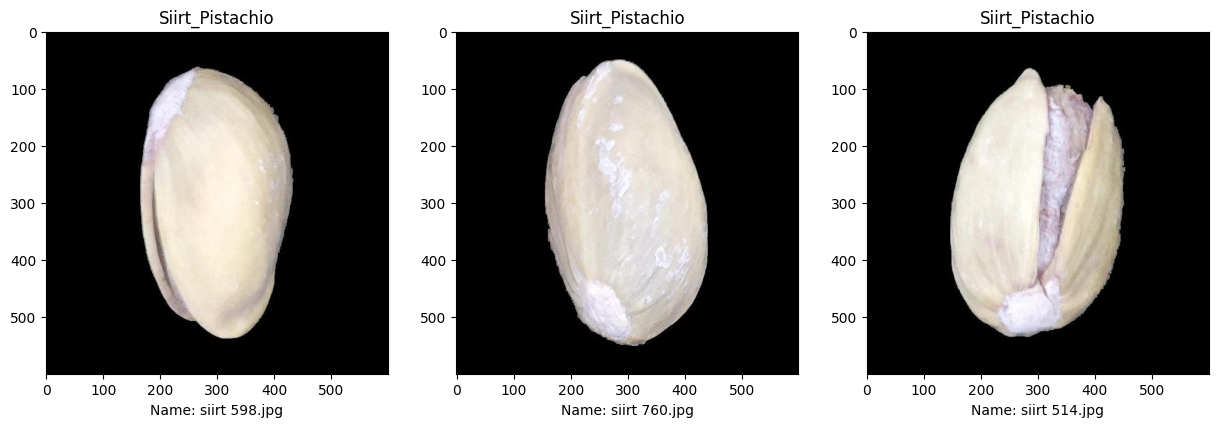

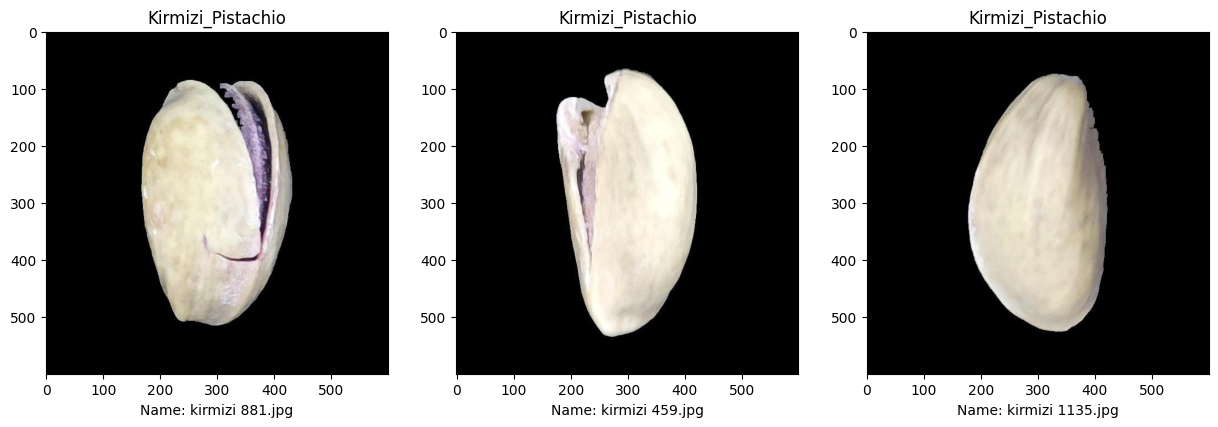

In [ ]:
for label in labels:
    load_random_imgs_from_folder(f"{data_dir}/{label}",label)

## 1.3 - Image Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

val_generator = test_val_datagen.flow_from_directory(directory = val_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 1717 images belonging to 2 classes.
Found 214 images belonging to 2 classes.
Found 217 images belonging to 2 classes.


In [ ]:
data_train = image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=0,
    color_mode="rgb",
    image_size=(img_size,img_size),
    batch_size=32,
)
data_test = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=0,
    color_mode="rgb",
    image_size=(img_size,img_size),
    batch_size=32,
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Found 2148 files belonging to 2 classes.
Using 429 files for validation.


In [ ]:
# small train dataset with BATCH_SIZE*SMALL_DATASET_BATCHES images
train_data_small = data_train.take(5)

# 2- Modelling

I have used Transfer Learning using a pre-trained VGG16 Model.

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

Visual Representation of the model layers

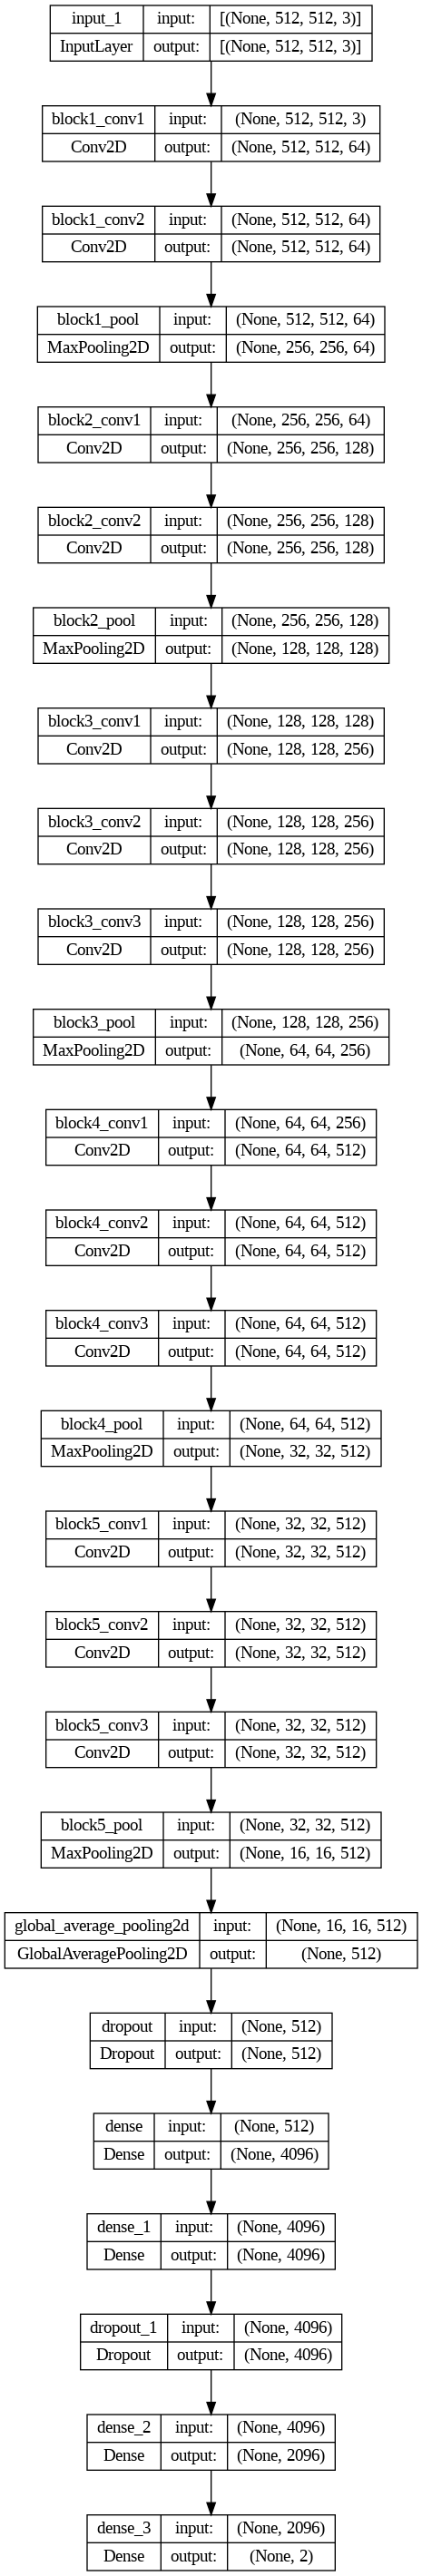

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

Callback to continually monitor the validation loss and stop the training of model when it overfits

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

In [ ]:
opt = Adam(learning_rate=0.005)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# 3- Training of Model

Reason for 50 epochs is that if the model begins to overfit or the validation loss does not decrease much then callback will automatically stop the training

In [ ]:
history=model.fit(data_train,
                  epochs=50,
                  validation_data=data_test,
                  validation_steps=int(0.1 * len(data_test)),
                  verbose=1,
                  callbacks=callbacks)

Epoch 1/50


This code pertains to training with augmented data. However, during my attempts, the model became stuck at a training accuracy of 57% before the callback was triggered. Therefore, I decided to first test on unaugmented data and then generate a new model for augmentation.

In [ ]:
# history = model.fit(train_generator,
#                     epochs = 50,
#                     validation_data = val_generator,
#                     verbose = 1)

# 4- Model Evaluation

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('./model.hdf5')

def learning_curve(model_fit, key='accuracy', ylim=(0, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
learning_curve(history,'loss', ylim=(0,1))
learning_curve(history, 'accuracy', ylim=(0,1))

In [ ]:
test_loss, test_acc = model.evaluate(data_test, steps=len(data_test), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0))

In [ ]:
# test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
# print('Loss: %.3f' % (test_loss * 100.0))
# print('Accuracy: %.3f' % (test_acc * 100.0))